# Brain Tumor Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj 

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
To: /content/brain_tumor.zip
100% 156M/156M [00:03<00:00, 49.0MB/s]


In [3]:
!unzip -q brain_tumor.zip

In [4]:
ls -l

total 152152
-rw-r--r-- 1 root root 155791278 Feb 26 17:52 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Feb 23 14:38 sample_data/
drwxr-xr-x 6 root root      4096 Feb 26 17:52 Testing/
drwxr-xr-x 6 root root      4096 Feb 26 17:52 Training/


In [5]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (42.8 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 128208 files and directories currently install

In [6]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma [1321 entries exceeds filelimit, not opening dir]
├── meningioma [1339 entries exceeds filelimit, not opening dir]
├── notumor [1595 entries exceeds filelimit, not opening dir]
└── pituitary [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma [300 entries exceeds filelimit, not opening dir]
├── meningioma [306 entries exceeds filelimit, not opening dir]
├── notumor [405 entries exceeds filelimit, not opening dir]
└── pituitary [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from tensorflow.keras import layers, models

print('TF Version:', tf.__version__)

TF Version: 2.11.0


## Utility functions to create dataset generators

In [9]:
IMG_DIMS = (224, 224)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# The function helps to get data into train and validation splits
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE
    )

    train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                        .map(lambda image, label: (tf.image.random_brightness(image, 0.2), label))
                        .map(lambda image, label: (tf.image.random_hue(image, 0.1), label))
                        .map(lambda image, label: (tf.image.random_saturation(image, 0.75, 1.25), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# The function helps to get prediction labels on the test data
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions



In [10]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


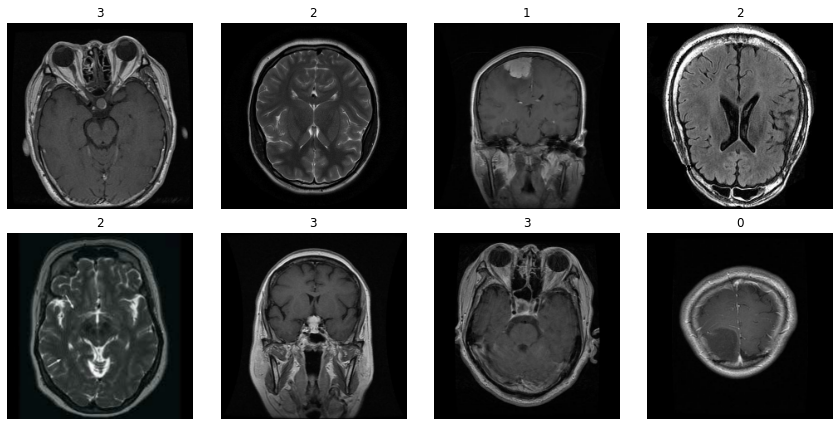

In [11]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

# Baseline model

In [12]:
b_model = models.Sequential()
b_model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMG_SHAPE))
b_model.add(layers.MaxPooling2D((2, 2)))
b_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
b_model.add(layers.MaxPooling2D((2, 2)))
b_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
b_model.add(layers.Flatten())
b_model.add(layers.Dense(256, activation='relu')) #256
b_model.add(layers.Dense(256, activation='relu')) #256
b_model.add(layers.Dropout(0.2))
b_model.add(layers.Dense(len(classes), activation='softmax'))

b_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [13]:
b_model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics = ['sparse_categorical_accuracy'])


In [14]:
history = b_model.fit(
    train_ds, epochs=10, 
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(b_model)

Epoch 1/10
143/143 [==============================] - 26s 43ms/step - loss: 11.2216 - sparse_categorical_accuracy: 0.6856 - val_loss: 0.5392 - val_sparse_categorical_accuracy: 0.8091
Epoch 2/10
143/143 [==============================] - 16s 42ms/step - loss: 0.4463 - sparse_categorical_accuracy: 0.8389 - val_loss: 0.4372 - val_sparse_categorical_accuracy: 0.8476
Epoch 3/10
143/143 [==============================] - 15s 40ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.8803 - val_loss: 0.3746 - val_sparse_categorical_accuracy: 0.8669
Epoch 4/10
143/143 [==============================] - 16s 40ms/step - loss: 0.2527 - sparse_categorical_accuracy: 0.9112 - val_loss: 0.3573 - val_sparse_categorical_accuracy: 0.8879
Epoch 5/10
143/143 [==============================] - 15s 40ms/step - loss: 0.2198 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.3698 - val_sparse_categorical_accuracy: 0.8914
Epoch 6/10
143/143 [==============================] - 16s 40ms/step - loss: 0.1760 - spar

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.12s/it]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.83it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.77it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:02,  3.49it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.21it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:01,  4.87it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:00,  5.37it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.71it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  5.96it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.30it/s]

1/1 [==============================] - 0s 249ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]


In [32]:
def plot_training_history(history, metric):
    """function for plotting training history. This plots the classification accuracy and loss-values recorded during training with the Keras API."""
    
    val_metric = 'val_'+metric
    acc = history.history[metric]
    val_acc = history.history[val_metric]
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = history.epoch
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Acc.')
    plt.plot(epochs_range, val_acc, label='Validation Acc.')
    plt.legend(loc='best',)
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')
    plt.show()


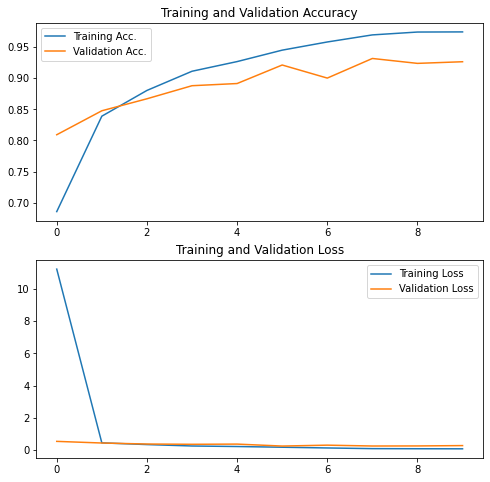

In [16]:
lst_metrics = ['sparse_categorical_accuracy']
plot_training_history(history,lst_metrics[0])

In [17]:
print(classification_report(y_true=y_true, y_pred=np.argmax(y_pred, axis=1),
                            target_names=classes))

              precision    recall  f1-score   support

      glioma       0.99      0.84      0.91       300
  meningioma       0.85      0.91      0.88       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



# ResNet

In [47]:
model_name = 'resnet50_v01'

# load a new instance of the model.
model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE, #(224, 224, 3)
                                                include_top=True # Or reshape the pictures as (224,224,3)
                                                )

In [48]:
last_conv_layer = model.get_layer('conv5_block3_out')

In [49]:
conv_model = models.Model(inputs=model.input,
                   outputs=last_conv_layer.output)

# Start a new Keras Sequential model.
new_model = models.Sequential()

# Add the convolutional part of the model from above.
new_model.add(conv_model)

# the resnet model uses a global average pooling layer before the final dense layer
# other models may just flatten the final convolutional layer or 
# use other pooling layers so make sure to check the original model architecture
new_model.add(tf.keras.layers.GlobalAveragePooling2D())

new_model.add(tf.keras.layers.Dense(256, activation='relu'))
new_model.add(tf.keras.layers.Dense(256, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.2))

# Add a final dense (aka. fully-connected) layer.
# This is for combining features recognized in the image and calculating predictions 
# note that the number of nodes is the sameas the number of classes 
new_model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

# you could experiment with adding other layers like a dropout-layer which may prevent overfitting 
# but we will exclude this for now and stick to the original model architecture

In [50]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 1028      
                                                      

In [51]:
new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, use_ema=True),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics = ['sparse_categorical_accuracy'])

In [52]:
history = new_model.fit(train_ds,
                        epochs=10,
                        batch_size=BATCH_SIZE,
                        validation_data=val_ds
                        )

Epoch 1/10
143/143 [==============================] - 92s 353ms/step - loss: 0.7567 - sparse_categorical_accuracy: 0.7265 - val_loss: 0.9320 - val_sparse_categorical_accuracy: 0.6340
Epoch 2/10
143/143 [==============================] - 58s 343ms/step - loss: 0.2859 - sparse_categorical_accuracy: 0.9090 - val_loss: 0.6358 - val_sparse_categorical_accuracy: 0.7294
Epoch 3/10
143/143 [==============================] - 58s 345ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.9462 - val_loss: 0.5163 - val_sparse_categorical_accuracy: 0.7942
Epoch 4/10
143/143 [==============================] - 58s 342ms/step - loss: 0.1168 - sparse_categorical_accuracy: 0.9628 - val_loss: 0.2276 - val_sparse_categorical_accuracy: 0.9203
Epoch 5/10
143/143 [==============================] - 58s 343ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.0997 - val_sparse_categorical_accuracy: 0.9658
Epoch 6/10
143/143 [==============================] - 58s 343ms/step - loss: 0.0684 -

In [53]:
y_true, y_pred = eval_model_on_test(new_model)
print(classification_report(y_true=y_true, y_pred=np.argmax(y_pred, axis=1),
                            target_names=classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 91ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:18,  1.88s/it]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:09,  1.05s/it]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:06,  1.28it/s]

4/4 [==============================] - 0s 95ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:04,  1.51it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:03<00:03,  1.69it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:02,  1.80it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:02,  1.88it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:05<00:01,  1.94it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:05<00:01,  1.99it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:06<00:00,  2.05it/s]

1/1 [==============================] - 1s 861ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.95      0.98      0.96       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



# Fine-Tuning: Unlocking layers for training

In [54]:
len(conv_model.layers)

175

In [55]:
# open some layers in the convolution layer (except batch normalization)
num_unfreeze = 4
conv_model.trainable = False
for layer in conv_model.layers[-num_unfreeze:]: 
   if('bn' not in layer.name): #
    layer.trainable = True

In [56]:
for layer in conv_model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))


False:	input_2
False:	conv1_pad
False:	conv1_conv
False:	conv1_bn
False:	conv1_relu
False:	pool1_pad
False:	pool1_pool
False:	conv2_block1_1_conv
False:	conv2_block1_1_bn
False:	conv2_block1_1_relu
False:	conv2_block1_2_conv
False:	conv2_block1_2_bn
False:	conv2_block1_2_relu
False:	conv2_block1_0_conv
False:	conv2_block1_3_conv
False:	conv2_block1_0_bn
False:	conv2_block1_3_bn
False:	conv2_block1_add
False:	conv2_block1_out
False:	conv2_block2_1_conv
False:	conv2_block2_1_bn
False:	conv2_block2_1_relu
False:	conv2_block2_2_conv
False:	conv2_block2_2_bn
False:	conv2_block2_2_relu
False:	conv2_block2_3_conv
False:	conv2_block2_3_bn
False:	conv2_block2_add
False:	conv2_block2_out
False:	conv2_block3_1_conv
False:	conv2_block3_1_bn
False:	conv2_block3_1_relu
False:	conv2_block3_2_conv
False:	conv2_block3_2_bn
False:	conv2_block3_2_relu
False:	conv2_block3_3_conv
False:	conv2_block3_3_bn
False:	conv2_block3_add
False:	conv2_block3_out
False:	conv3_block1_1_conv
False:	conv3_block1_1_bn
Fal

In [57]:
def lrf(epoch):
  l_initial = 1e-5
  k = np.log(20) / 20
  return (l_initial * np.exp(-k*epoch))
  
lrate = tf.keras.callbacks.LearningRateScheduler(lrf)

new_model.compile(optimizer = tf.keras.optimizers.Adam(use_ema=True, epsilon=1e-8),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics = ['sparse_categorical_accuracy'])

In [58]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
learning_rate_cb = tf.keras.callbacks.LearningRateScheduler(lrf)

In [59]:
history = new_model.fit(train_ds,
                        epochs=50,
                        validation_data=val_ds,
                        callbacks = [early_stopping_cb, learning_rate_cb]
                        ) 

Epoch 1/50
143/143 [==============================] - 31s 128ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0694 - val_sparse_categorical_accuracy: 0.9755 - lr: 1.0000e-05
Epoch 2/50
143/143 [==============================] - 26s 124ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0629 - val_sparse_categorical_accuracy: 0.9772 - lr: 8.6089e-06
Epoch 3/50
143/143 [==============================] - 26s 122ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0688 - val_sparse_categorical_accuracy: 0.9755 - lr: 7.4113e-06
Epoch 4/50
143/143 [==============================] - 26s 121ms/step - loss: 0.0068 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0695 - val_sparse_categorical_accuracy: 0.9746 - lr: 6.3804e-06
Epoch 5/50
143/143 [==============================] - 26s 122ms/step - loss: 0.0067 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0665 - val_sparse_categorical_accuracy: 0.9746 - lr: 5.4928e-06


In [60]:
y_true, y_pred = eval_model_on_test(new_model)

print(classification_report(y_true=y_true, y_pred=np.argmax(y_pred, axis=1),
                            target_names=classes))

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 92ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:19,  1.93s/it]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:09,  1.08s/it]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:06,  1.25it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:04,  1.49it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:03<00:03,  1.68it/s]

4/4 [==============================] - 0s 91ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:02,  1.81it/s]

4/4 [==============================] - 0s 94ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:02,  1.91it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:05<00:01,  1.99it/s]

4/4 [==============================] - 0s 93ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:05<00:00,  2.04it/s]

4/4 [==============================] - 0s 92ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:06<00:00,  2.08it/s]

1/1 [==============================] - 1s 868ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]

              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       300
  meningioma       0.95      0.98      0.96       306
     notumor       0.99      1.00      0.99       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

